In [1]:
import cv2
import numpy as np
import os
import pandas as pd
from glob import glob
import time
import matplotlib.pyplot as plt
import random

import warnings
warnings.filterwarnings('ignore')

In [2]:
MASK_FILES = [
    r"NIH-NLM-ThinBloodSmearsPf\Polygon Set\209C68P29N_ThinF\Masks\IMG_20150819_133236.png",
    r"NIH-NLM-ThinBloodSmearsPf\Polygon Set\231C89P50ThinF\Masks\IMG_20150820_162153.png",
    r"NIH-NLM-ThinBloodSmearsPf\Polygon Set\306C213ThinF\Masks\IMG_20151106_112252.png",
    r"NIH-NLM-ThinBloodSmearsPf\Polygon Set\362C177P138NThinF\Masks\IMG_20151201_142846.png",
    r"NIH-NLM-ThinBloodSmearsPf\Polygon Set\156C55P16thinF\Masks\IMG_20150728_123237.png"
]

# Main Functions

In [3]:
def create_dataset_from_list(mask_paths_list):
    dataset = []
    
    for mask_path in mask_paths_list:
        mask_path = os.path.normpath(mask_path)
        img_path = mask_path.replace("Masks", "Img").replace(".png", ".jpg")
        
        basename = os.path.basename(mask_path)
        img_id = os.path.splitext(basename)[0]
        
        if not os.path.exists(img_path):
            print(f"Warning: Image not found at predicted path: {img_path}")
        
        dataset.append({
            "id": img_id,
            "img_path": img_path,
            "mask_path": mask_path
        })
            
    return dataset

In [4]:
def get_channel(img_rgb, mode='green'):
    if mode == 'green':
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        g_c = clahe.apply(img_rgb[:, :, 1])
        green_inverted = 255 - g_c

        gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
        _, roi_mask = cv2.threshold(gray, 15, 255, cv2.THRESH_BINARY)

        img_green = cv2.bitwise_and(green_inverted, green_inverted, mask=roi_mask)
        return img_green

    elif mode == 'hue':
        hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
        h, s, v = cv2.split(hsv)

        _, v_mask = cv2.threshold(v, 30, 255, cv2.THRESH_BINARY)

        img_hue = cv2.bitwise_and(h, h, mask=v_mask)
        return img_hue

    else:
        return cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

def refine_mask(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filled_mask = np.zeros_like(mask)
    cv2.drawContours(filled_mask, contours, -1, 255, -1)
    
    kernel = np.ones((3,3), np.uint8)
    filled_mask = cv2.morphologyEx(filled_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    
    return filled_mask

In [20]:
def run_otsu(img_gray, img_rgb, params):
    blur_ksize = params.get('blur_ksize', 0)
    morph_kernel_size = params.get('morph_kernel_size', 0)
    min_area = params.get('min_area', 50)
    
    if blur_ksize > 0:
        if blur_ksize % 2 == 0: blur_ksize += 1
        img_proc = cv2.GaussianBlur(img_gray, (blur_ksize, blur_ksize), 0)
    else:
        img_proc = img_gray

    _, binary = cv2.threshold(img_proc, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    if morph_kernel_size > 0:
        kernel = np.ones((morph_kernel_size, morph_kernel_size), np.uint8)
        #binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=1)
        binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=1)
    
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary)
    
    clean_mask = np.zeros_like(binary)
    
    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        if area > min_area:
            clean_mask[labels == i] = 255
            
    return clean_mask


def run_watershed(img_gray, img_rgb, params):
    blur_ksize = params.get('blur_ksize', 0)
    morph_kernel_size = params.get('morph_kernel_size', 3)
    dist_mask_size = params.get('dist_mask_size', 5)
    dist_thresh_ratio = params.get('dist_thresh_ratio', 0.5)
    min_area = params.get('min_area', 50)
    
    if blur_ksize > 0:
        if blur_ksize % 2 == 0: blur_ksize += 1
        img_proc = cv2.GaussianBlur(img_gray, (blur_ksize, blur_ksize), 0)
    else:
        img_proc = img_gray
        
    _, binary = cv2.threshold(img_proc, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    if morph_kernel_size > 0:
        kernel = np.ones((morph_kernel_size, morph_kernel_size), np.uint8)
        #closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)
        opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
    else:
        opening = binary
        kernel = np.ones((3, 3), np.uint8)

    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, dist_mask_size)
    
    if dist_transform.max() == 0: 
        return np.zeros_like(img_gray)
    
    _, sure_fg = cv2.threshold(dist_transform, dist_thresh_ratio * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    
    unknown = cv2.subtract(sure_bg, sure_fg)
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    markers = cv2.watershed(img_rgb, markers)
    
    unique, counts = np.unique(markers, return_counts=True)
    
    valid_labels = []
    for label, count in zip(unique, counts):
        if label > 1 and count > min_area:
            valid_labels.append(label)
            
    object_mask = np.isin(markers, valid_labels).astype(np.uint8) * 255
    
    return object_mask


def run_hough(img_gray, img_rgb, params):
    blur_ksize = params.get('blur_ksize', 5)
    dp = params.get('dp', 1.2)
    minDist = params.get('minDist', 35)
    param1 = params.get('param1', 50)
    param2 = params.get('param2', 30)
    min_radius = params.get('min_radius', 15)
    max_radius = params.get('max_radius', 80)
    
    if blur_ksize > 0:
        if blur_ksize % 2 == 0: blur_ksize += 1
        blur = cv2.medianBlur(img_gray, blur_ksize)
    else:
        blur = img_gray
    
    circles = cv2.HoughCircles(
        blur, cv2.HOUGH_GRADIENT, dp=dp, minDist=minDist,
        param1=param1, param2=param2, minRadius=min_radius, maxRadius=max_radius
    )
    
    final_mask = np.zeros_like(img_gray)
    
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            cv2.circle(final_mask, (i[0], i[1]), i[2], 255, -1)
            
    return final_mask

In [6]:
def calculate_metrics(pred_mask, gt_mask):
    _, pred_bin = cv2.threshold(pred_mask, 127, 255, cv2.THRESH_BINARY)
    _, gt_bin = cv2.threshold(gt_mask, 127, 255, cv2.THRESH_BINARY)
    
    #IoU
    intersection = cv2.bitwise_and(pred_bin, gt_bin)
    union = cv2.bitwise_or(pred_bin, gt_bin)
    
    area_inter = cv2.countNonZero(intersection)
    area_union = cv2.countNonZero(union)
    
    iou = area_inter / area_union if area_union > 0 else 0.0
    
    #Precision/Recall based on Centroids
    num_pred, _, _, centroids_pred = cv2.connectedComponentsWithStats(pred_bin)
    
    num_gt, _, _, _ = cv2.connectedComponentsWithStats(gt_bin)
    count_pred = num_pred - 1
    count_gt = num_gt - 1
    
    tp = 0
    fp = 0
    
    for i in range(1, num_pred):
        cx, cy = int(centroids_pred[i][0]), int(centroids_pred[i][1])
        
        if gt_bin[cy, cx] == 255:
            tp += 1
        else:
            fp += 1
            
    fn = count_gt - tp
    if fn < 0: fn = 0 
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        "iou": round(iou, 3),
        "precision": round(precision, 3),
        "recall": round(recall, 3),
        "f1": round(f1, 3),
        "count_pred": count_pred,
        "count_gt": count_gt,
        "count_diff": abs(count_pred - count_gt)
    }

In [17]:
def overlay_blue_mask(img_rgb, mask, alpha=0.3):
    overlay = img_rgb.copy()
    overlay[mask == 255] = [7, 175, 18]
    return cv2.addWeighted(overlay, alpha, img_rgb, 1 - alpha, 0)

# Experiment

In [ ]:
CONFIG = {
    "Otsu_Green": {
        "func": run_otsu,
        "channel": "green",
        "params": {"blur_ksize": 0, "morph_kernel_size": 3, "min_area": 50}
    },
    "Otsu_Hue": {
        "func": run_otsu,
        "channel": "hue",
        "params": {"blur_ksize": 0, "morph_kernel_size": 3, "min_area": 50}
    },
    "Watershed_Green": {
        "func": run_watershed,
        "channel": "green",
        "params": {"blur_ksize": 0, "dist_mask_size": 3, "dist_thresh_ratio": 0.2, "min_area": 75}
    },
    "Watershed_Hue": {
        "func": run_watershed,
        "channel": "hue",
        "params": {"blur_ksize": 0, "dist_mask_size": 3, "dist_thresh_ratio": 0.2, "min_area": 75}
    },
    "Hough_Green": {
        "func": run_hough,
        "channel": "green",
        "params": {"blur_ksize": 5, "param1": 50, "param2": 35, "min_radius": 50, , "max_radius": 80}
    }
}

Loaded 5 pairs for testing.


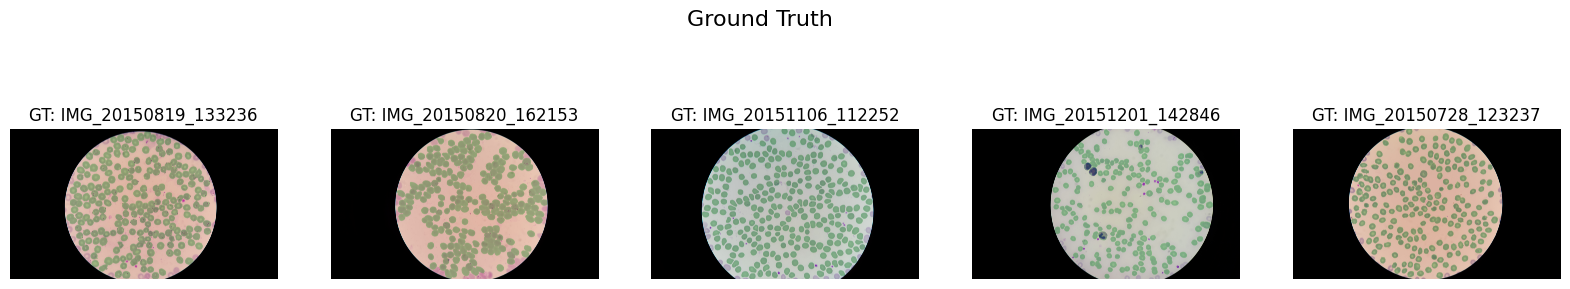

Running Otsu_Green


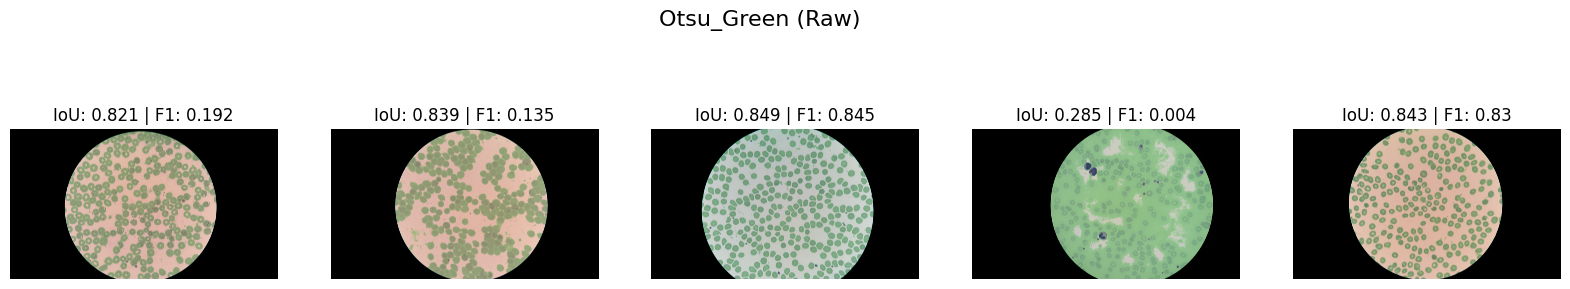

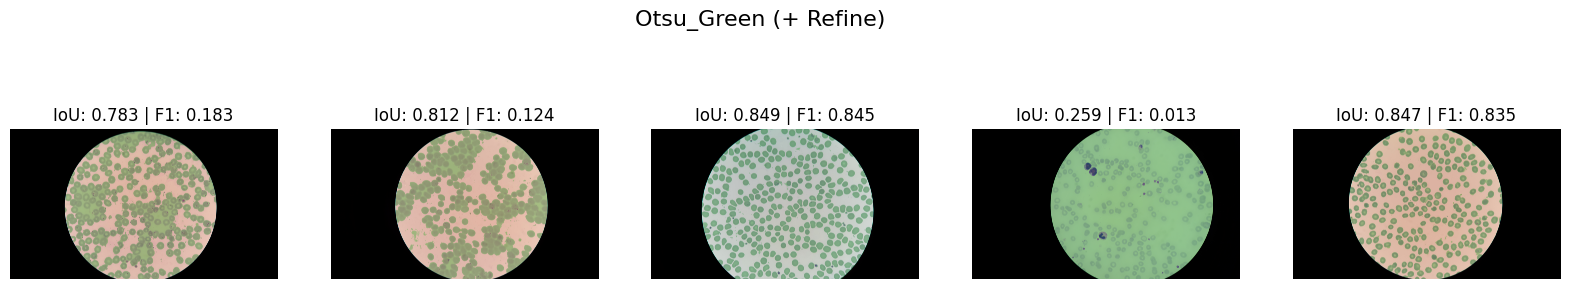

Running Otsu_Hue


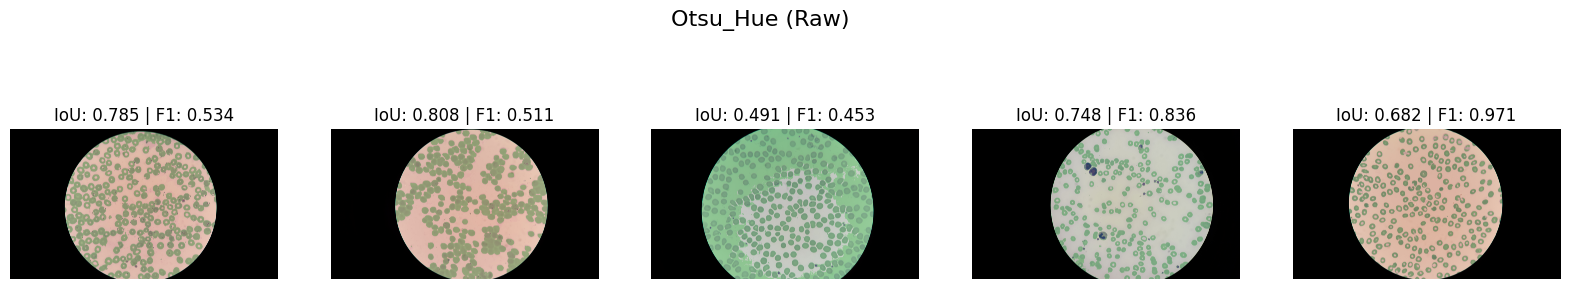

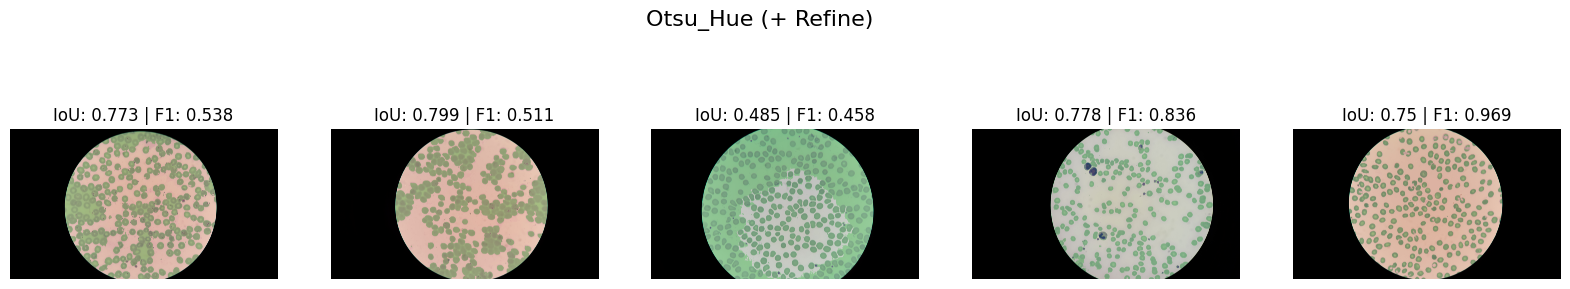

Running Watershed_Green


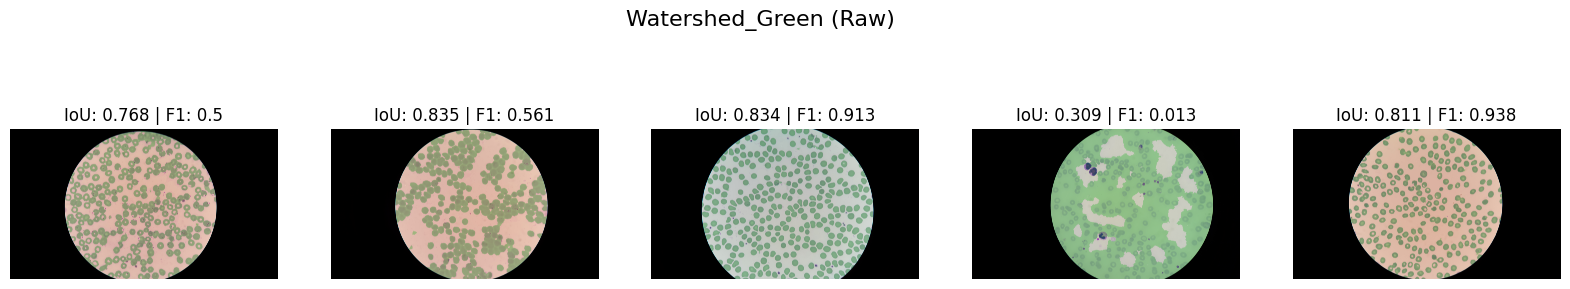

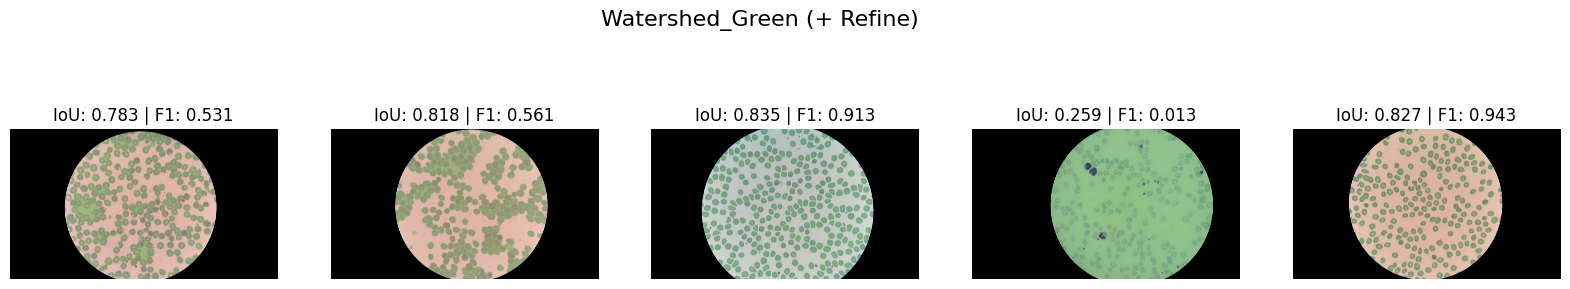

Running Watershed_Hue


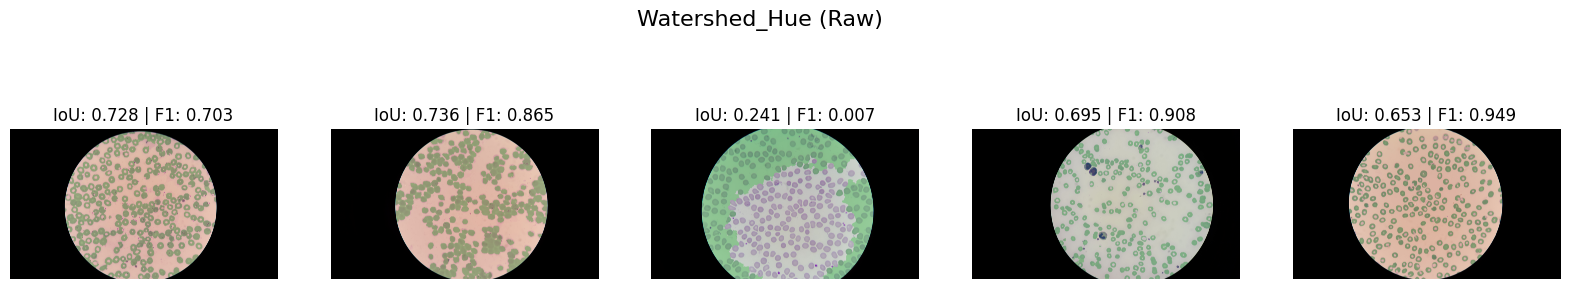

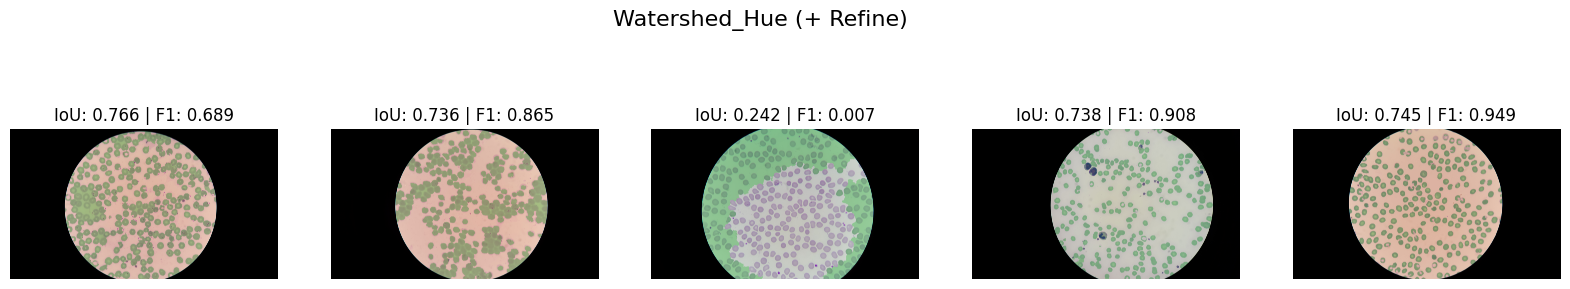

Running Hough_Green


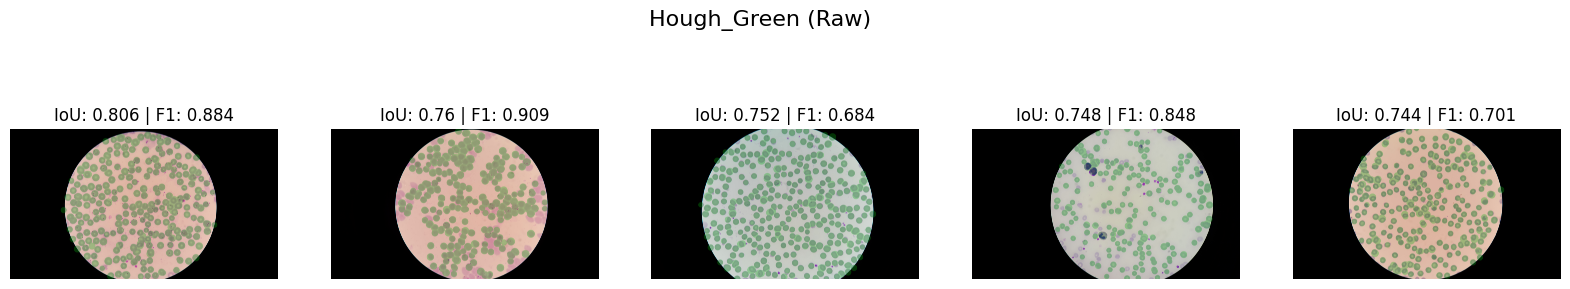

In [52]:
dataset = create_dataset_from_list(MASK_FILES)
print(f"Loaded {len(dataset)} pairs for testing.")

results = []

plt.figure(figsize=(20, 4))
plt.suptitle("Ground Truth", fontsize=16)

for i, data in enumerate(dataset):
    if not os.path.exists(data['img_path']): continue
    
    img_rgb = cv2.imread(data['img_path'])
    img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
    gt_mask = cv2.imread(data['mask_path'], cv2.IMREAD_GRAYSCALE)
    
    vis_gt = overlay_blue_mask(img_rgb, gt_mask)
    
    plt.subplot(1, 5, i + 1)
    plt.imshow(vis_gt)
    plt.title(f"GT: {data['id']}")
    plt.axis('off')
plt.show()

if len(dataset) > 0:
    for method_name, config in CONFIG.items():
        print(f"Running {method_name}")
        
        is_hough = "Hough" in method_name
        
        fig_raw = plt.figure(figsize=(20, 4))
        fig_raw.suptitle(f"{method_name} (Raw)", fontsize=16)
        
        if not is_hough:
            fig_ref = plt.figure(figsize=(20, 4))
            fig_ref.suptitle(f"{method_name} (+ Refine)", fontsize=16)

        for i, data in enumerate(dataset):
            if not os.path.exists(data['img_path']): continue
                
            img_rgb = cv2.imread(data['img_path'])
            img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
            gt_mask = cv2.imread(data['mask_path'], cv2.IMREAD_GRAYSCALE)
            
            start_time = time.time()
            
            img_gray = get_channel(img_rgb, config['channel'])
            
            raw_mask = config['func'](img_gray, img_rgb, config['params'])
            
            raw_time_elapsed = time.time() - start_time
            
            metrics_raw = calculate_metrics(raw_mask, gt_mask)
            res_raw = metrics_raw.copy()
            res_raw['method'] = f"{method_name} (Raw)"
            res_raw['image_id'] = data['id']
            res_raw['time_sec'] = raw_time_elapsed
            results.append(res_raw)
            
            plt.figure(fig_raw.number)
            vis_res = overlay_blue_mask(img_rgb, raw_mask)
            plt.subplot(1, 5, i + 1)
            plt.imshow(vis_res)
            plt.title(f"IoU: {metrics_raw['iou']} | F1: {metrics_raw['f1']}")
            plt.axis('off')
            
            if is_hough:
                refined_mask = raw_mask
                total_time_elapsed = raw_time_elapsed
            else:
                refine_start = time.time()
                refined_mask = refine_mask(raw_mask)
                refine_duration = time.time() - refine_start
                total_time_elapsed = raw_time_elapsed + refine_duration
                
                metrics_ref = calculate_metrics(refined_mask, gt_mask)
                res_ref = metrics_ref.copy()
                res_ref['method'] = f"{method_name} (+ Refine)"
                res_ref['image_id'] = data['id']
                res_ref['time_sec'] = total_time_elapsed
                results.append(res_ref)

                plt.figure(fig_ref.number)
                vis_res_ref = overlay_blue_mask(img_rgb, refined_mask)
                plt.subplot(1, 5, i + 1)
                plt.imshow(vis_res_ref)
                plt.title(f"IoU: {metrics_ref['iou']} | F1: {metrics_ref['f1']}")
                plt.axis('off')
        
        plt.show()


In [55]:
df_results = pd.DataFrame(results)
summary = df_results.groupby('method')[['iou', 'f1', 'count_diff', 'time_sec']].mean()
print(summary.sort_values(by='f1', ascending=False))

                               iou      f1  count_diff  time_sec
method                                                          
Hough_Green (Raw)           0.7620  0.8052        38.0  0.702230
Watershed_Hue (Raw)         0.6106  0.6864        70.0  1.223662
Watershed_Hue (+ Refine)    0.6454  0.6836        70.0  1.276181
Otsu_Hue (+ Refine)         0.7170  0.6624        50.0  3.392276
Otsu_Hue (Raw)              0.7028  0.6610        48.8  3.344609
Watershed_Green (+ Refine)  0.7044  0.5922        48.2  1.494642
Watershed_Green (Raw)       0.7114  0.5850        48.2  1.439006
Otsu_Green (Raw)            0.7274  0.4012        89.2  6.513219
Otsu_Green (+ Refine)       0.7100  0.4000        75.2  6.561909


# Problem with images 3 and 4. Binarization??

In [39]:
dataset

[{'id': 'IMG_20150819_133236',
  'img_path': 'NIH-NLM-ThinBloodSmearsPf\\Polygon Set\\209C68P29N_ThinF\\Img\\IMG_20150819_133236.jpg',
  'mask_path': 'NIH-NLM-ThinBloodSmearsPf\\Polygon Set\\209C68P29N_ThinF\\Masks\\IMG_20150819_133236.png'},
 {'id': 'IMG_20150820_162153',
  'img_path': 'NIH-NLM-ThinBloodSmearsPf\\Polygon Set\\231C89P50ThinF\\Img\\IMG_20150820_162153.jpg',
  'mask_path': 'NIH-NLM-ThinBloodSmearsPf\\Polygon Set\\231C89P50ThinF\\Masks\\IMG_20150820_162153.png'},
 {'id': 'IMG_20151106_112252',
  'img_path': 'NIH-NLM-ThinBloodSmearsPf\\Polygon Set\\306C213ThinF\\Img\\IMG_20151106_112252.jpg',
  'mask_path': 'NIH-NLM-ThinBloodSmearsPf\\Polygon Set\\306C213ThinF\\Masks\\IMG_20151106_112252.png'},
 {'id': 'IMG_20151201_142846',
  'img_path': 'NIH-NLM-ThinBloodSmearsPf\\Polygon Set\\362C177P138NThinF\\Img\\IMG_20151201_142846.jpg',
  'mask_path': 'NIH-NLM-ThinBloodSmearsPf\\Polygon Set\\362C177P138NThinF\\Masks\\IMG_20151201_142846.png'},
 {'id': 'IMG_20150728_123237',
  'img_

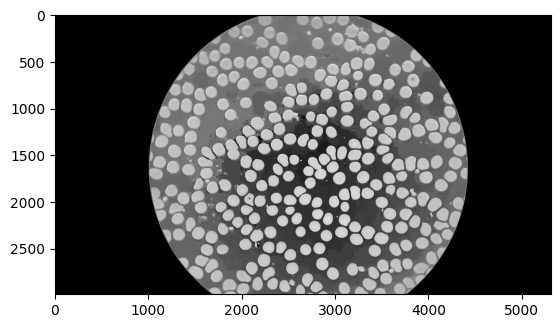

In [59]:
img = dataset[2]
img_rgb = cv2.imread(img['img_path'])
img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
img_hue = get_channel(img_rgb, "hue")
plt.imshow(img_hue, cmap='gray')

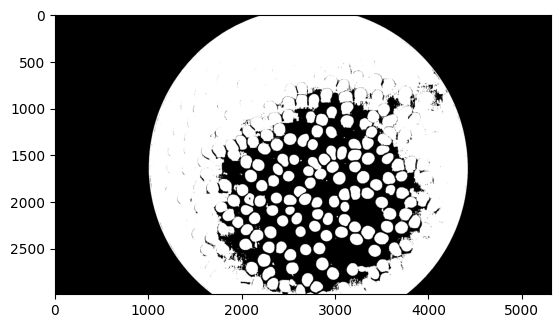

In [60]:
_, binary = cv2.threshold(img_hue, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(binary, cmap='gray')

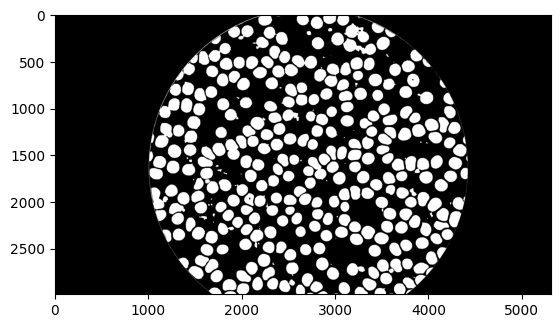

In [64]:
valid_h = img_hue[img_hue > 0]
th_h, _ = cv2.threshold(valid_h, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
_, bin_h = cv2.threshold(img_hue, th_h, 255, cv2.THRESH_BINARY)
plt.imshow(bin_h, cmap='gray')

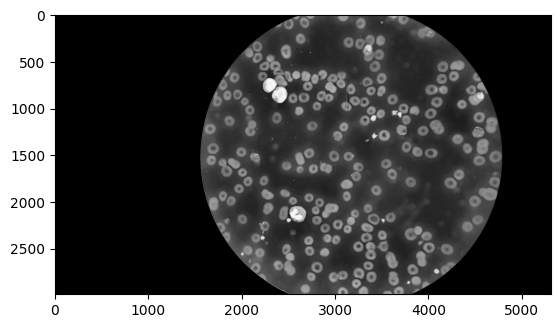

In [62]:
img = dataset[3]
img_rgb = cv2.imread(img['img_path'])
img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
img_green = get_channel(img_rgb, "green")
plt.imshow(img_green, cmap='gray')

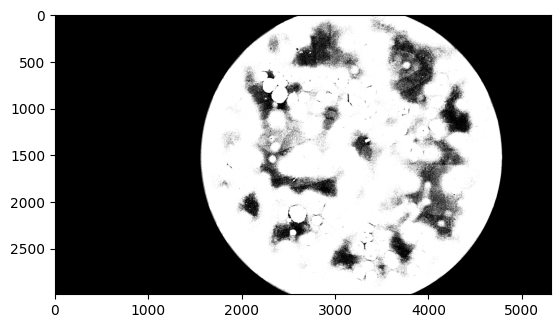

In [56]:
_, binary = cv2.threshold(img_green, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(binary, cmap='gray')

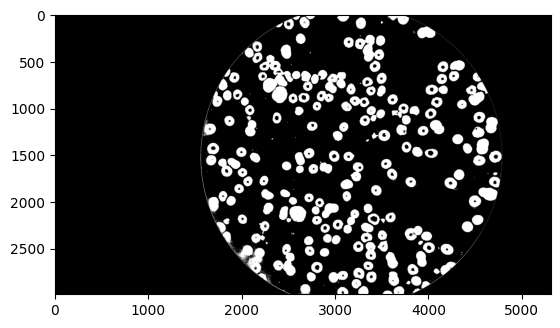

In [63]:
valid_g = img_green[img_green > 0]
th_g, _ = cv2.threshold(valid_g, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
_, bin_g = cv2.threshold(img_green, th_g, 255, cv2.THRESH_BINARY)
plt.imshow(bin_g, cmap='gray')

# Fix binarization

In [7]:
def run_otsu_fixed(img_gray, img_rgb, params):
    blur_ksize = params.get('blur_ksize', 0)
    morph_kernel_size = params.get('morph_kernel_size', 0)
    min_area = params.get('min_area', 50)
    
    if blur_ksize > 0:
        if blur_ksize % 2 == 0: blur_ksize += 1
        img_proc = cv2.GaussianBlur(img_gray, (blur_ksize, blur_ksize), 0)
    else:
        img_proc = img_gray
    
    otsu_thresh, _ = cv2.threshold(img_proc[img_proc > 0], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, binary = cv2.threshold(img_proc, otsu_thresh, 255, cv2.THRESH_BINARY)
    
    if morph_kernel_size > 0:
        kernel = np.ones((morph_kernel_size, morph_kernel_size), np.uint8)
        binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=1)
        binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=1)
    
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary)
    
    clean_mask = np.zeros_like(binary)
    
    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        if area > min_area:
            clean_mask[labels == i] = 255
            
    return clean_mask


def run_watershed_fixed(img_gray, img_rgb, params):
    blur_ksize = params.get('blur_ksize', 0)
    morph_kernel_size = params.get('morph_kernel_size', 3)
    dist_mask_size = params.get('dist_mask_size', 5)
    dist_thresh_ratio = params.get('dist_thresh_ratio', 0.5)
    min_area = params.get('min_area', 50)
    
    if blur_ksize > 0:
        if blur_ksize % 2 == 0: blur_ksize += 1
        img_proc = cv2.GaussianBlur(img_gray, (blur_ksize, blur_ksize), 0)
    else:
        img_proc = img_gray
        
    otsu_thresh, _ = cv2.threshold(img_proc[img_proc > 0], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, binary = cv2.threshold(img_proc, otsu_thresh, 255, cv2.THRESH_BINARY)
    
    if morph_kernel_size > 0:
        kernel = np.ones((morph_kernel_size, morph_kernel_size), np.uint8)
        #binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)
        opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
    else:
        opening = binary
        kernel = np.ones((3, 3), np.uint8)

    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, dist_mask_size)
    
    if dist_transform.max() == 0: 
        return np.zeros_like(img_gray)
    
    _, sure_fg = cv2.threshold(dist_transform, dist_thresh_ratio * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    
    unknown = cv2.subtract(sure_bg, sure_fg)
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    markers = cv2.watershed(img_rgb, markers)
    
    unique, counts = np.unique(markers, return_counts=True)
    
    valid_labels = []
    for label, count in zip(unique, counts):
        if label > 1 and count > min_area:
            valid_labels.append(label)
            
    object_mask = np.isin(markers, valid_labels).astype(np.uint8) * 255
    
    return object_mask

In [8]:
CONFIG_FIXED = {
    "Otsu_Green": {
        "func": run_otsu_fixed,
        "channel": "green",
        "params": {"blur_ksize": 0, "morph_kernel_size": 3, "min_area": 50}
    },
    "Otsu_Hue": {
        "func": run_otsu_fixed,
        "channel": "hue",
        "params": {"blur_ksize": 0, "morph_kernel_size": 3, "min_area": 50}
    },
    "Watershed_Green": {
        "func": run_watershed_fixed,
        "channel": "green",
        "params": {"blur_ksize": 0, "dist_mask_size": 3, "dist_thresh_ratio": 0.2, "min_area": 75}
    },
    "Watershed_Hue": {
        "func": run_watershed_fixed,
        "channel": "hue",
        "params": {"blur_ksize": 0, "dist_mask_size": 3, "dist_thresh_ratio": 0.2, "min_area": 75}
    },
    "Hough_Green": {
        "func": run_hough,
        "channel": "green",
        "params": {"blur_ksize": 5, "param1": 50, "param2": 35, "min_radius": 50, "max_radius": 80}
    }
}

Loaded 5 pairs for testing.


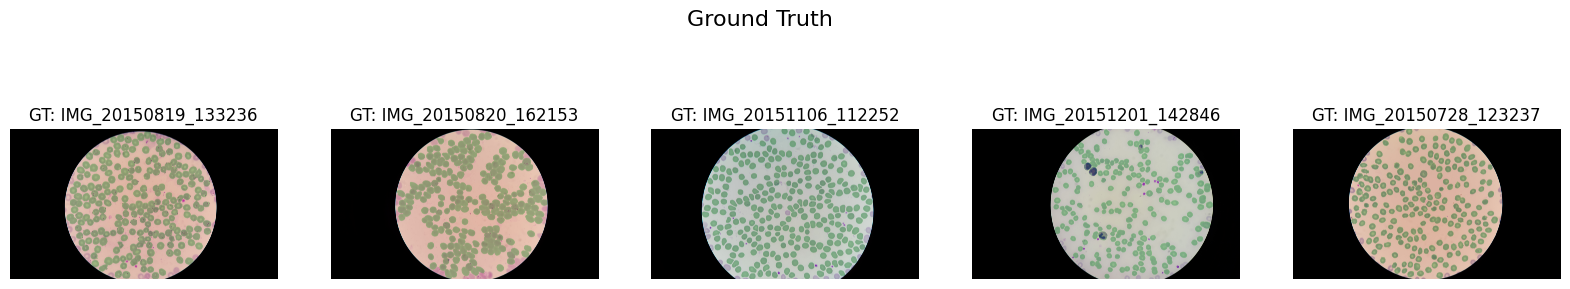

Running Otsu_Green


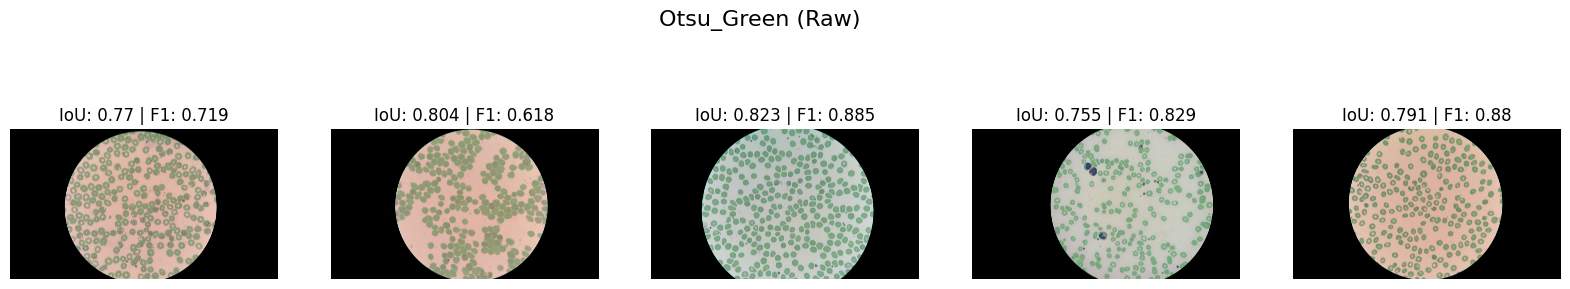

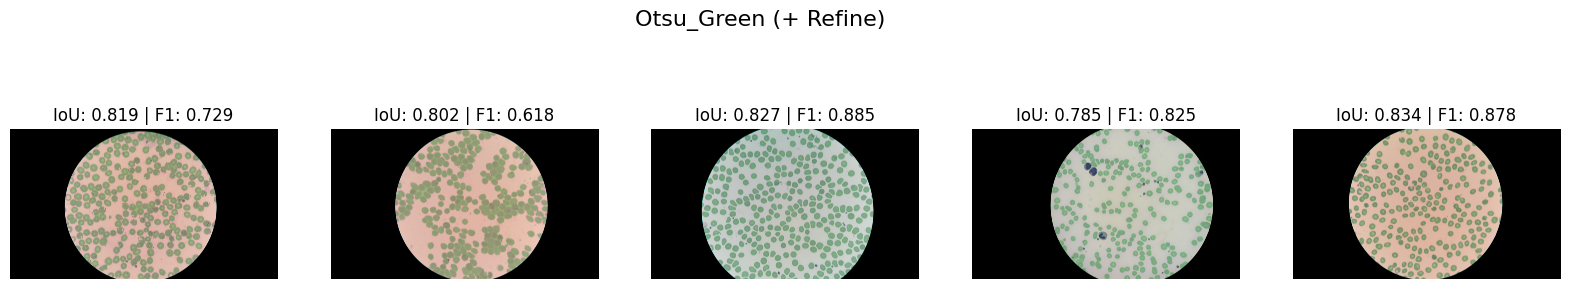

Running Otsu_Hue


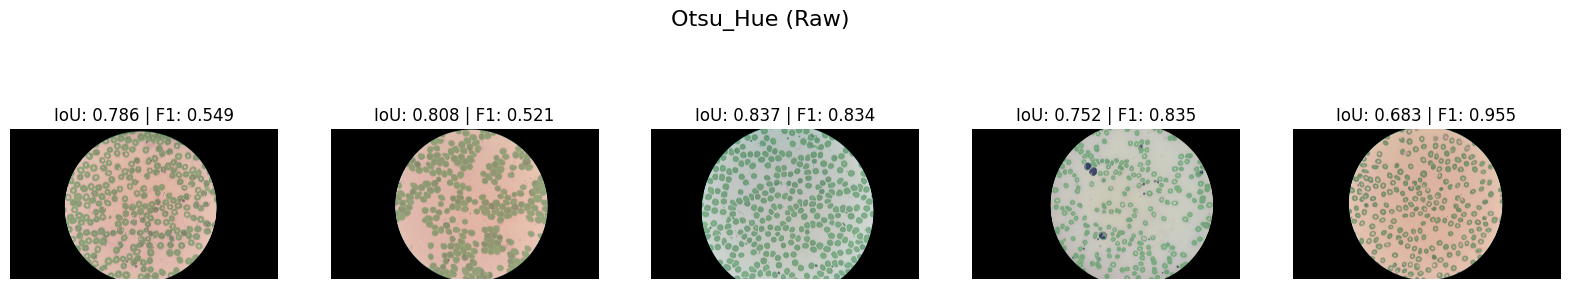

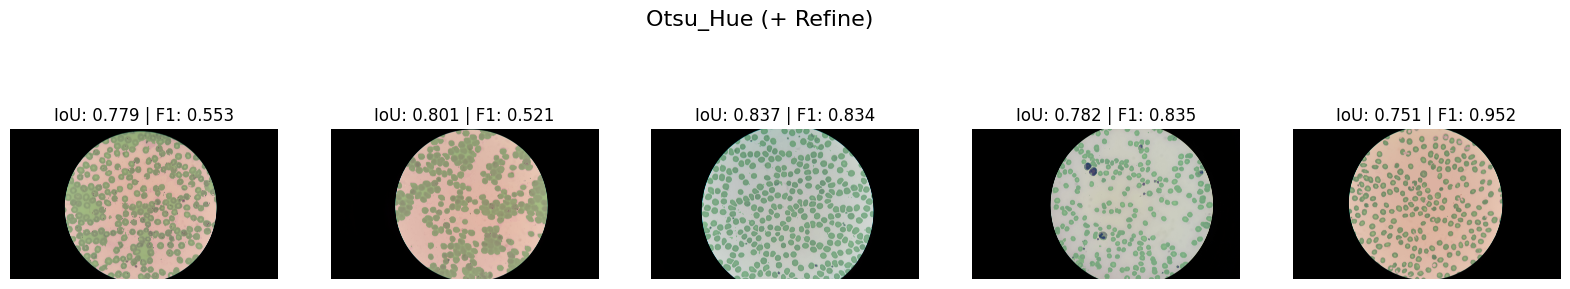

Running Watershed_Green


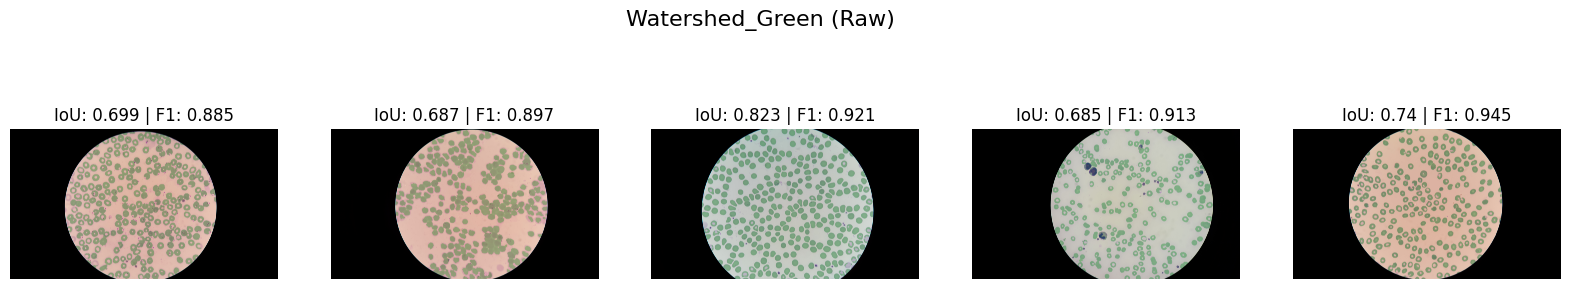

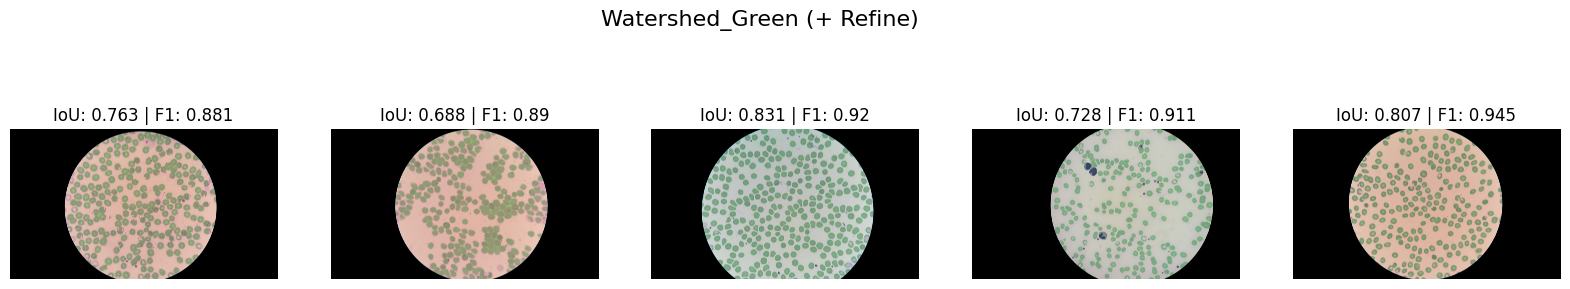

Running Watershed_Hue


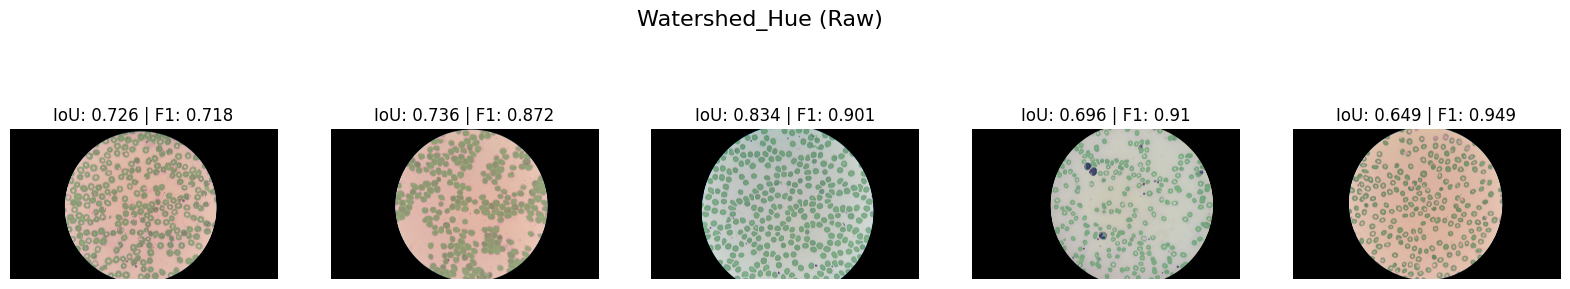

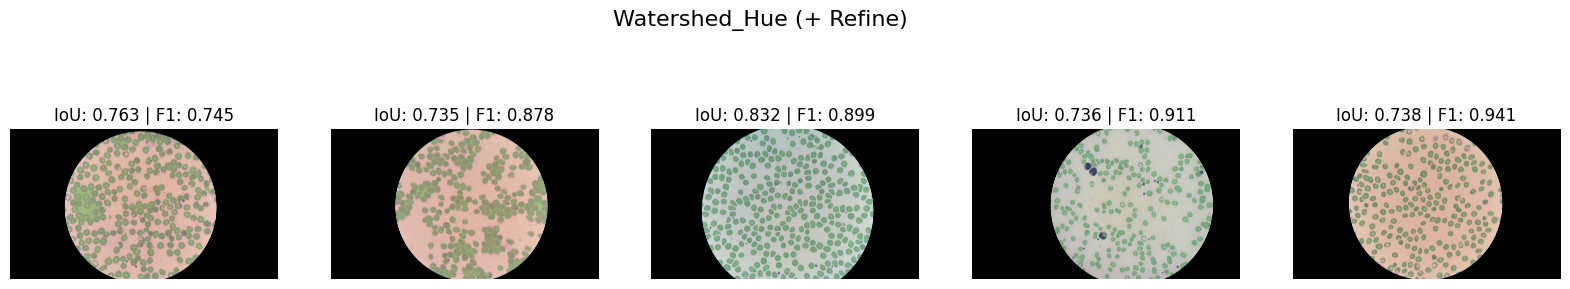

Running Hough_Green


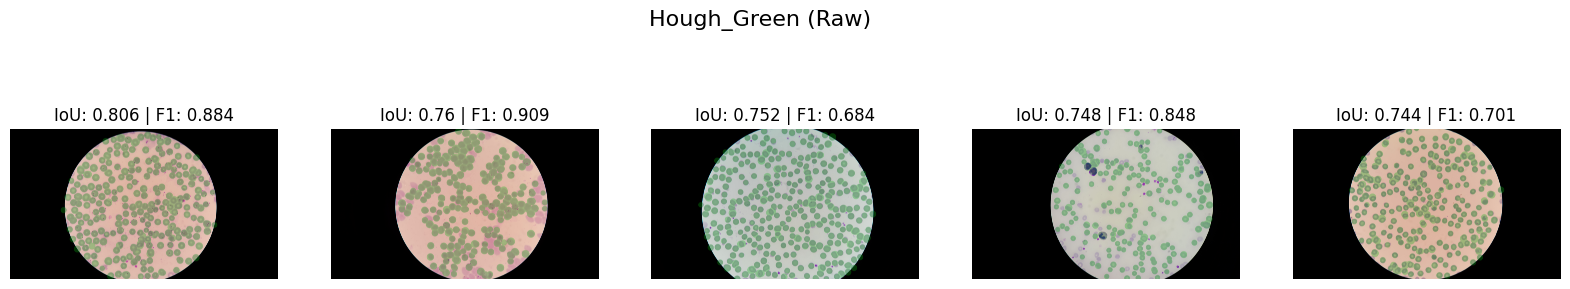

In [19]:
dataset = create_dataset_from_list(MASK_FILES)
print(f"Loaded {len(dataset)} pairs for testing.")

results_fixed = []

plt.figure(figsize=(20, 4))
plt.suptitle("Ground Truth", fontsize=16)

for i, data in enumerate(dataset):
    if not os.path.exists(data['img_path']): continue
    
    img_rgb = cv2.imread(data['img_path'])
    img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
    gt_mask = cv2.imread(data['mask_path'], cv2.IMREAD_GRAYSCALE)
    
    vis_gt = overlay_blue_mask(img_rgb, gt_mask)
    
    plt.subplot(1, 5, i + 1)
    plt.imshow(vis_gt)
    plt.title(f"GT: {data['id']}")
    plt.axis('off')
plt.show()

if len(dataset) > 0:
    for method_name, config in CONFIG_FIXED.items():
        print(f"Running {method_name}")
        
        is_hough = "Hough" in method_name
        
        fig_raw = plt.figure(figsize=(20, 4))
        fig_raw.suptitle(f"{method_name} (Raw)", fontsize=16)
        
        if not is_hough:
            fig_ref = plt.figure(figsize=(20, 4))
            fig_ref.suptitle(f"{method_name} (+ Refine)", fontsize=16)

        for i, data in enumerate(dataset):
            if not os.path.exists(data['img_path']): continue
                
            img_rgb = cv2.imread(data['img_path'])
            img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
            gt_mask = cv2.imread(data['mask_path'], cv2.IMREAD_GRAYSCALE)
            
            start_time = time.time()
            
            img_gray = get_channel(img_rgb, config['channel'])
            
            raw_mask = config['func'](img_gray, img_rgb, config['params'])
            
            raw_time_elapsed = time.time() - start_time
            
            metrics_raw = calculate_metrics(raw_mask, gt_mask)
            res_raw = metrics_raw.copy()
            res_raw['method'] = f"{method_name} (Raw)"
            res_raw['image_id'] = data['id']
            res_raw['time_sec'] = raw_time_elapsed
            results_fixed.append(res_raw)
            
            plt.figure(fig_raw.number)
            vis_res = overlay_blue_mask(img_rgb, raw_mask)
            plt.subplot(1, 5, i + 1)
            plt.imshow(vis_res)
            plt.title(f"IoU: {metrics_raw['iou']} | F1: {metrics_raw['f1']}")
            plt.axis('off')
            
            if is_hough:
                refined_mask = raw_mask
                total_time_elapsed = raw_time_elapsed
            else:
                refine_start = time.time()
                refined_mask = refine_mask(raw_mask)
                refine_duration = time.time() - refine_start
                total_time_elapsed = raw_time_elapsed + refine_duration
                
                metrics_ref = calculate_metrics(refined_mask, gt_mask)
                res_ref = metrics_ref.copy()
                res_ref['method'] = f"{method_name} (+ Refine)"
                res_ref['image_id'] = data['id']
                res_ref['time_sec'] = total_time_elapsed
                results_fixed.append(res_ref)

                plt.figure(fig_ref.number)
                vis_res_ref = overlay_blue_mask(img_rgb, refined_mask)
                plt.subplot(1, 5, i + 1)
                plt.imshow(vis_res_ref)
                plt.title(f"IoU: {metrics_ref['iou']} | F1: {metrics_ref['f1']}")
                plt.axis('off')
        
        plt.show()

In [20]:
df_results_fixed = pd.DataFrame(results_fixed)
summary = df_results_fixed.groupby('method')[['iou', 'f1', 'count_diff', 'time_sec']].mean()
print(summary.sort_values(by='f1', ascending=False))

                               iou      f1  count_diff  time_sec
method                                                          
Watershed_Green (Raw)       0.7268  0.9122        51.0  1.316408
Watershed_Green (+ Refine)  0.7634  0.9094        53.6  1.391617
Watershed_Hue (+ Refine)    0.7608  0.8748        29.6  1.366425
Watershed_Hue (Raw)         0.7282  0.8700        26.4  1.297021
Hough_Green (Raw)           0.7620  0.8052        38.0  1.001608
Otsu_Green (+ Refine)       0.8134  0.7870        52.8  4.744246
Otsu_Green (Raw)            0.7886  0.7862        52.8  4.684365
Otsu_Hue (+ Refine)         0.7900  0.7390        42.4  4.543023
Otsu_Hue (Raw)              0.7732  0.7388        42.2  4.478229


# Full Dataset Evaluation

In [19]:
FINAL_CONFIG = {
    "Watershed_Green (Refine)": {
        "func": run_watershed_fixed, 
        "channel": "green",
        "params": {"blur_ksize": 0, "dist_mask_size": 3, "dist_thresh_ratio": 0.2, "min_area": 75},
        "use_refine": True
    },
    "Hough_Green (Raw)": {
        "func": run_hough, 
        "channel": "green",
        "params": {"blur_ksize": 5, "param1": 50, "param2": 35, "min_radius": 55, "max_radius": 85},
        "use_refine": False
    }
}

In [11]:
DATASET_ROOT_PATH = os.path.join("NIH-NLM-ThinBloodSmearsPf", "Polygon Set")

In [12]:
def find_images_and_masks_structure(root_dir):
    pairs = []
    
    if not os.path.exists(root_dir):
        print(f"Error: Folder '{root_dir}' not found")
        return []

    patient_folders = [f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))]
    
    print(f"Found {len(patient_folders)} patient folders in '{root_dir}'")

    for patient in patient_folders:
        patient_path = os.path.join(root_dir, patient)
        img_dir = os.path.join(patient_path, 'Img')
        gt_dir = os.path.join(patient_path, 'Masks')
            
        valid_extensions = ('.jpg', '.png')
        image_files = [f for f in os.listdir(img_dir) if f.lower().endswith(valid_extensions)]
        
        for img_file in image_files:
            base_name = os.path.splitext(img_file)[0]
            
            mask_file = None
            for ext in valid_extensions:
                candidate = base_name + ext
                if os.path.exists(os.path.join(gt_dir, candidate)):
                    mask_file = candidate
                    break
            
            if mask_file:
                pairs.append({
                    'id': f"{patient}_{img_file}",
                    'img_path': os.path.join(img_dir, img_file),
                    'mask_path': os.path.join(gt_dir, mask_file)
                })

    return pairs

In [13]:
full_dataset = find_images_and_masks_structure(DATASET_ROOT_PATH)
final_results = []

print(f"Total valid pairs found: {len(full_dataset)}")

Found 33 patient folders in 'NIH-NLM-ThinBloodSmearsPf\Polygon Set'
Total valid pairs found: 165


In [26]:
for i, data in enumerate(full_dataset):
    print(f"Processing {i+1}/{len(full_dataset)}: {data['id']}", end='\r')
    
    img_rgb = cv2.imread(data['img_path'])

    img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
    
    gt_mask = cv2.imread(data['mask_path'], cv2.IMREAD_GRAYSCALE)
    
    for method_name, config in FINAL_CONFIG.items():
        start_time = time.time()
        
        img_channel = get_channel(img_rgb, config['channel'])
        pred_mask = config['func'](img_channel, img_rgb, config['params'])
        
        if config['use_refine']:
            pred_mask = refine_mask(pred_mask)
            
        exec_time = time.time() - start_time
        
        metrics = calculate_metrics(pred_mask, gt_mask)
        
        res_entry = metrics.copy()
        res_entry['method'] = method_name
        res_entry['image_id'] = data['id']
        res_entry['time_sec'] = exec_time
        final_results.append(res_entry)

In [27]:
df_final = pd.DataFrame(final_results)
summary_table = df_final.groupby('method')[['iou', 'f1', 'count_diff', 'time_sec']].mean()
print(summary_table.sort_values(by='f1', ascending=False).round(4))

                              iou      f1  count_diff  time_sec
method                                                         
Watershed_Green (+Refine)  0.7913  0.9201     38.1212    1.4768
Hough_Green (Raw)          0.7630  0.7482     48.4121    0.9783


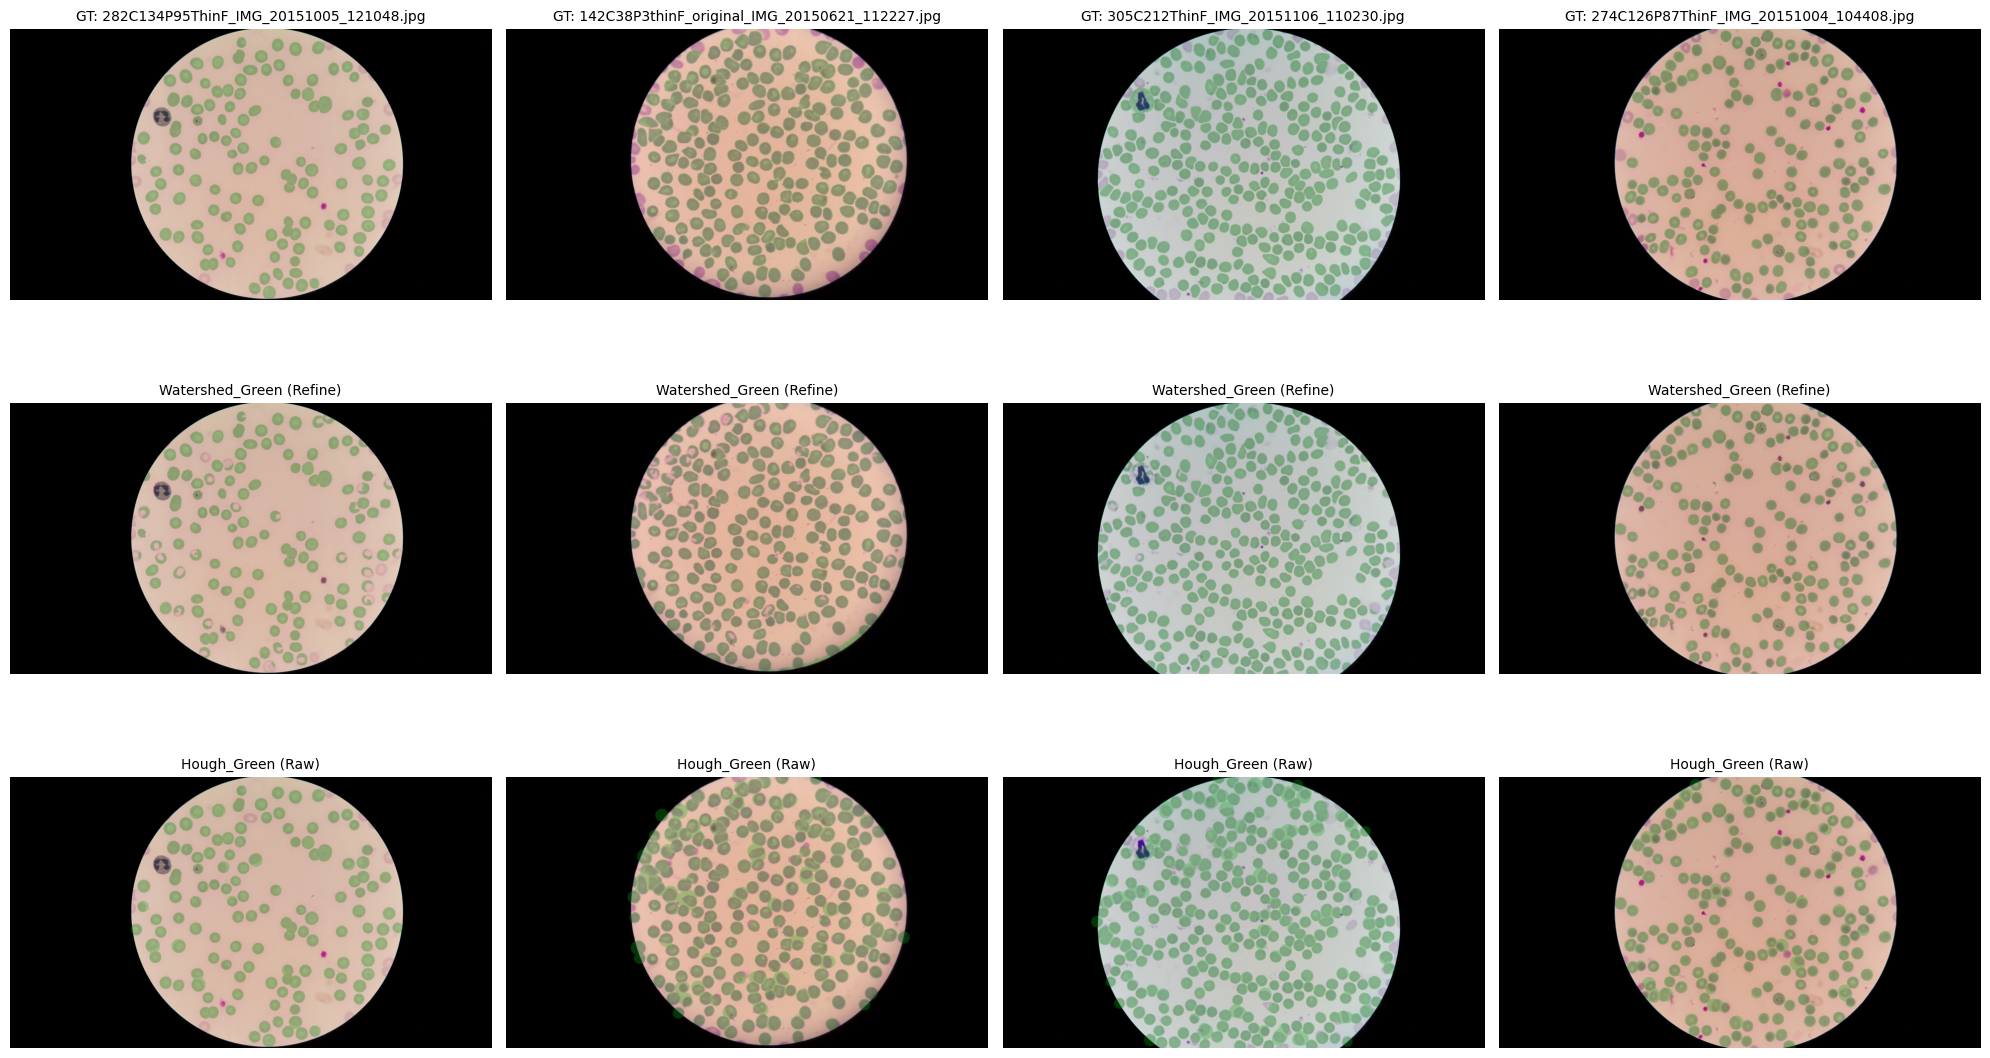

In [21]:
num_samples = 4
safe_samples = min(len(full_dataset), num_samples)
sample_indices = random.sample(range(len(full_dataset)), safe_samples)
samples = [full_dataset[i] for i in sample_indices]

rows = 1 + len(FINAL_CONFIG)
cols = len(samples)

plt.figure(figsize=(5 * cols, 4 * rows))

for col_idx, data in enumerate(samples):
    img_rgb = cv2.imread(data['img_path'])
    img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
    gt_mask = cv2.imread(data['mask_path'], cv2.IMREAD_GRAYSCALE)
    
    vis_gt = overlay_blue_mask(img_rgb, gt_mask)
    plt.subplot(rows, cols, col_idx + 1)
    plt.imshow(vis_gt)
    plt.title(f"GT: {data['id']}", fontsize=10)
    plt.axis('off')

    row_idx = 1
    for method_name, config in FINAL_CONFIG.items():
        img_channel = get_channel(img_rgb, config['channel'])
        mask = config['func'](img_channel, img_rgb, config['params'])
        if config['use_refine']:
            mask = refine_mask(mask)
            
        vis_pred = overlay_blue_mask(img_rgb, mask)
        
        plt.subplot(rows, cols, row_idx * cols + col_idx + 1)
        plt.imshow(vis_pred)
        
        plt.title(method_name, fontsize=10)
        plt.axis('off')
        
        row_idx += 1

plt.tight_layout()
plt.show()